In [ ]:
# Try out with window size of 16 and check how much minimum data needed for a days, weeks, etc prediction 
# Read about Trajectory temporal mapping using CNN and transformers

In [1]:
# Dependencies for running the model
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
# Dependencies for data extraction
import netCDF4 as NC
import glob
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
#from numpy.fft import fft, ifft
from scipy.signal import welch
from scipy.fftpack import fft, ifft
from scipy.fftpack import fftfreq

In [3]:
# Data extraction part
path = os.getcwd()
path=os.path.join(path,"data")
temporary = os.listdir(path)
data_files = glob.glob(path+os.sep+'hyd_temp_*.nc')

A=[]
U=[]

time = np.empty([0])
Temperature_values_loc = np.empty([0])
a_smallest = 321768
u_smallest = 321768

for i in range(len(data_files)):
    Data_filename = NC.Dataset(data_files[i],'r')
    time = np.append(time, Data_filename['time'])
    # print(Data_filename['plevel'][0])
    if i%2==0:
      #Temperature_values_loc_a = np.append(Temperature_values_loc_a, Data_filename['TMP_prl'][:,0,1,1])
      #time_a = np.append(time_a, Data_filename['time'])
      A.append(Data_filename['TMP_prl'][:,0,1,1])

      a_smallest = min(a_smallest,len(A[-1]))

    else:
      # Temperature_values_loc_u = np.append(Temperature_values_loc_u, Data_filename['TMP_prl'][:,0,1,1])
      # time_u = np.append(time_u, Data_filename['time'])
      U.append(Data_filename['TMP_prl'][:,0,1,1])

      u_smallest = min(u_smallest, len(U[-1])) 

#temp_data = list(zip(time,Temperature_values_loc))
#temp_df=pd.DataFrame(temp_data ,columns=["time","Temperature"])

# for month:-
a_month=[]
u_month=[]

A=np.array(A)
U=np.array(U)

temp1=A[:][:2880]
temp2=U[:][:2880]

a_num=0
u_num=0

for i in range(16):
  if i%2==0:
    for j in range(12):
      if j%2==0:
        a_month.append(temp1[a_num][240*j:240*(j+1)])
            
      else:
        u_month.append(temp1[a_num][240*j:240*(j+1)])
      
    a_num=a_num + 1

  else:
    for j in range(12):
      if j%2==0:
        a_month.append(temp2[u_num][240*j:240*(j+1)])
    
      else:
        u_month.append(temp2[u_num][240*j:240*(j+1)])

    u_num=u_num+1

a_month=np.array(a_month)
u_month=np.array(u_month)

c:\Users\ASUS\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [4]:
# Preparing Dataframe
temp=[]

for i in range(8):
    temp.append(A[i])
    temp.append(U[i])

temp=[item for sublist in temp for item in sublist]
temp=np.array(temp)

In [5]:
Time=np.array([item for item in time])

df = pd.DataFrame({'Temp(K)': temp, 'Time': Time})

In [6]:
Time

array([6.3115200e+08, 6.3116280e+08, 6.3117360e+08, ..., 1.1360412e+09,
       1.1360520e+09, 1.1360628e+09])

In [7]:
# Making time as the index 
df.index = df['Time']
df

,Temp(K),Time
Time,,
6.311520e+08,294.323303,6.311520e+08
6.311628e+08,293.756348,6.311628e+08
6.311736e+08,295.595245,6.311736e+08
6.311844e+08,299.542053,6.311844e+08
6.311952e+08,301.178284,6.311952e+08
...,...,...
1.136020e+09,300.306488,1.136020e+09
1.136030e+09,299.925568,1.136030e+09
1.136041e+09,297.592316,1.136041e+09


In [8]:
# Normalizing temperature values

temp_mean = np.mean(df['Temp(K)'])
temp_std = np.std(df['Temp(K)'])

df['Temp(K)'] = (df['Temp(K)'] - temp_mean)/temp_std

In [9]:
temper = df['Temp(K)']
temper

Time
6.311520e+08   -1.690695
6.311628e+08   -1.819432
6.311736e+08   -1.401878
6.311844e+08   -0.505685
6.311952e+08   -0.134149
                  ...   
1.136020e+09   -0.332106
1.136030e+09   -0.418601
1.136041e+09   -0.948407
1.136052e+09   -1.241410
1.136063e+09   -1.444696
Name: Temp(K), Length: 46752, dtype: float32

In [10]:
# Creating the x and y labels :- the example is given below
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [11]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temper, WINDOW_SIZE)
X1.shape, y1.shape

((46747, 5, 1), (46747,))

In [12]:
# Split into train, validation and test sets

# X_train1, y_train1 = X1[:30000], y1[:30000]
# X_val1, y_val1 = X1[30000:40000], y1[30000:40000]
# X_test1, y_test1 = X1[40000:], y1[40000:]
# X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [14]:
# Preparing the first model which is CNN based
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(Conv1D(64, kernel_size=2))
model1.add(Flatten())
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 8)                 2056      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Setting hyperparameters
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

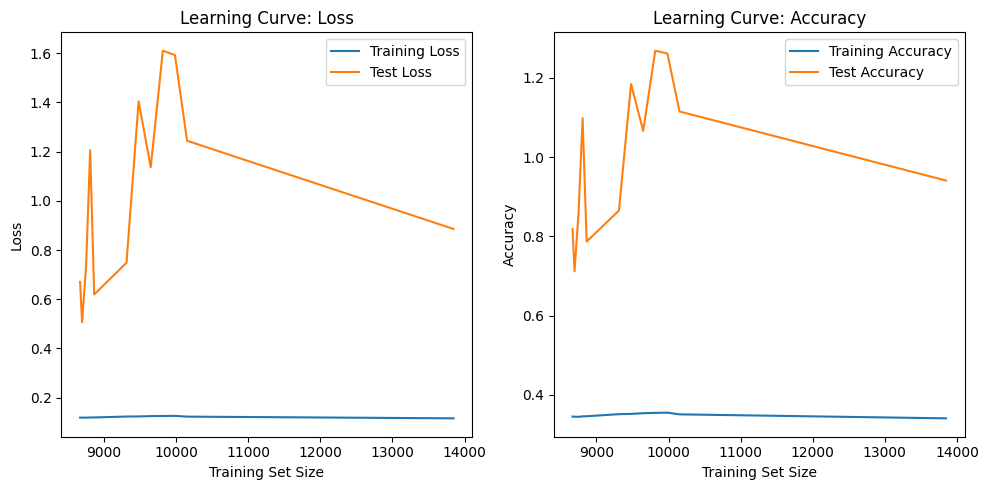

In [20]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Define a range of training set sizes to explore
training_sizes = [28, 56, 112, 168 , 224 , 672, 840, 1008 , 1176, 1344, 1512, 5208]  # sizes are 1,2 and 3 week, and months, etc 
training_sizes = np.array(training_sizes)
training_sizes = training_sizes + 8640

# Perform learning curve analysis
for size in training_sizes:
    # Take a subset of the training data
    X_train_subset = X1[:size]
    y_train_subset = y1[:size]
    
    # Define test set 
    X_test = X1[size : size + 8 ]
    y_test= X1[size : size + 8]

    # Train the model on the subset
    history = model1.fit(X_train_subset, y_train_subset, epochs=30, verbose=0)
    
    # Evaluate the model on training and test data
    train_loss, train_accuracy = model1.evaluate(X_train_subset, y_train_subset, verbose=0)
    test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=0)
    
    # Append results to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_sizes, train_losses, label='Training Loss')
plt.plot(training_sizes, test_losses, label='Test Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Training Set Size')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_sizes, train_accuracies, label='Training Accuracy')
plt.plot(training_sizes, test_accuracies, label='Test Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
915/938 [============================>.] - ETA: 0s - loss: 0.3942 - root_mean_squared_error: 0.6278

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 5s 4ms/step - loss: 0.3889 - root_mean_squared_error: 0.6236 - val_loss: 0.1647 - val_root_mean_squared_error: 0.4059
Epoch 2/10
916/938 [============================>.] - ETA: 0s - loss: 0.1454 - root_mean_squared_error: 0.3813

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1452 - root_mean_squared_error: 0.3810 - val_loss: 0.1306 - val_root_mean_squared_error: 0.3615
Epoch 3/10
915/938 [============================>.] - ETA: 0s - loss: 0.1310 - root_mean_squared_error: 0.3619

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 3s 4ms/step - loss: 0.1308 - root_mean_squared_error: 0.3616 - val_loss: 0.1285 - val_root_mean_squared_error: 0.3584
Epoch 4/10
933/938 [============================>.] - ETA: 0s - loss: 0.1288 - root_mean_squared_error: 0.3590

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1288 - root_mean_squared_error: 0.3588 - val_loss: 0.1275 - val_root_mean_squared_error: 0.3571
Epoch 5/10
921/938 [============================>.] - ETA: 0s - loss: 0.1276 - root_mean_squared_error: 0.3573

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1275 - root_mean_squared_error: 0.3570 - val_loss: 0.1258 - val_root_mean_squared_error: 0.3546
Epoch 6/10
923/938 [============================>.] - ETA: 0s - loss: 0.1264 - root_mean_squared_error: 0.3556

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1265 - root_mean_squared_error: 0.3557 - val_loss: 0.1249 - val_root_mean_squared_error: 0.3534
Epoch 7/10
918/938 [============================>.] - ETA: 0s - loss: 0.1260 - root_mean_squared_error: 0.3549

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1258 - root_mean_squared_error: 0.3547 - val_loss: 0.1247 - val_root_mean_squared_error: 0.3532
Epoch 8/10
919/938 [============================>.] - ETA: 0s - loss: 0.1255 - root_mean_squared_error: 0.3542

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1250 - root_mean_squared_error: 0.3535 - val_loss: 0.1244 - val_root_mean_squared_error: 0.3527
Epoch 9/10
928/938 [============================>.] - ETA: 0s - loss: 0.1243 - root_mean_squared_error: 0.3526

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1244 - root_mean_squared_error: 0.3527 - val_loss: 0.1235 - val_root_mean_squared_error: 0.3515
Epoch 10/10
921/938 [============================>.] - ETA: 0s - loss: 0.1236 - root_mean_squared_error: 0.3515

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1241 - root_mean_squared_error: 0.3523 - val_loss: 0.1233 - val_root_mean_squared_error: 0.3512


In [ ]:

model1 = load_model('model1/')

In [ ]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

938/938 [==============================] - 2s 2ms/step


,Train Predictions,Actuals
0,-0.349194,-0.634464
1,-0.963060,-0.995923
2,-1.341026,-1.679559
3,-1.618806,-1.765936
4,-1.346638,-1.781645
...,...,...
29995,0.595642,0.031640
29996,0.471311,-0.038265
29997,0.470327,1.370591
29998,2.054109,2.247312


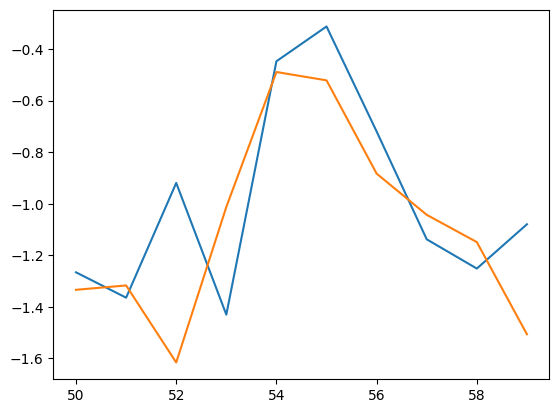

In [ ]:
# Plotting the results of train 
plt.plot(train_results['Train Predictions'][50:60])
plt.plot(train_results['Actuals'][50:60])

In [ ]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

313/313 [==============================] - 1s 2ms/step


,Val Predictions,Actuals
0,1.526947,1.879920
1,0.866473,1.739396
2,1.002726,1.393555
3,1.102968,1.286369
4,1.206649,0.920932
...,...,...
9995,-0.261195,-0.549687
9996,-0.364176,-0.695271
9997,-0.640567,0.133048
9998,0.782468,0.856043


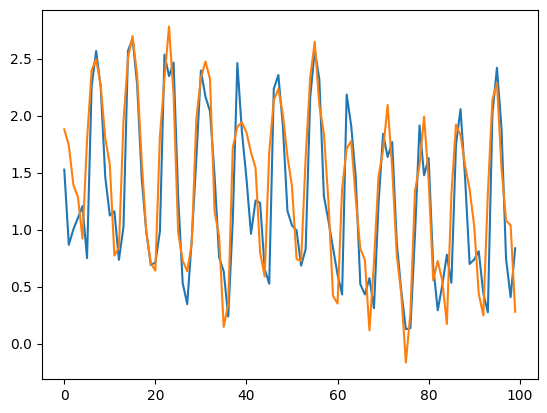

In [ ]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [ ]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

211/211 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,0.426480,0.796158
1,0.270687,0.621803
2,0.074448,-0.574551
3,-0.559920,-1.122395
4,-1.046423,-0.870110
...,...,...
6742,-0.144769,-0.332106
6743,-0.237180,-0.418601
6744,-0.804681,-0.948407
6745,-1.275325,-1.241410


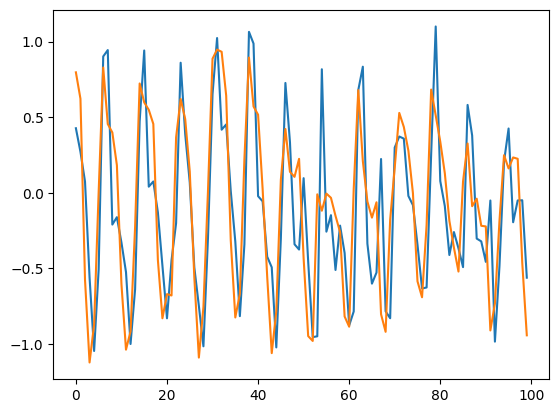

In [ ]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [ ]:
# LSTM based model

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error as mse

In [ ]:
def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

In [ ]:
plot_predictions1(model1, X_test1, y_test1)

NameError: name 'X_test1' is not defined

In [ ]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
930/938 [============================>.] - ETA: 0s - loss: 0.5589 - root_mean_squared_error: 0.7476

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


938/938 [==============================] - 16s 14ms/step - loss: 0.5571 - root_mean_squared_error: 0.7464 - val_loss: 0.3041 - val_root_mean_squared_error: 0.5515
Epoch 2/10
937/938 [============================>.] - ETA: 0s - loss: 0.1889 - root_mean_squared_error: 0.4346

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


938/938 [==============================] - 13s 14ms/step - loss: 0.1888 - root_mean_squared_error: 0.4345 - val_loss: 0.1459 - val_root_mean_squared_error: 0.3820
Epoch 3/10
934/938 [============================>.] - ETA: 0s - loss: 0.1460 - root_mean_squared_error: 0.3821

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


938/938 [==============================] - 13s 14ms/step - loss: 0.1460 - root_mean_squared_error: 0.3821 - val_loss: 0.1428 - val_root_mean_squared_error: 0.3778
Epoch 4/10
938/938 [==============================] - ETA: 0s - loss: 0.1420 - root_mean_squared_error: 0.3768

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


938/938 [==============================] - 13s 14ms/step - loss: 0.1420 - root_mean_squared_error: 0.3768 - val_loss: 0.1426 - val_root_mean_squared_error: 0.3776
Epoch 5/10
935/938 [============================>.] - ETA: 0s - loss: 0.1398 - root_mean_squared_error: 0.3739

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


938/938 [==============================] - 14s 15ms/step - loss: 0.1398 - root_mean_squared_error: 0.3740 - val_loss: 0.1391 - val_root_mean_squared_error: 0.3729
Epoch 6/10
935/938 [============================>.] - ETA: 0s - loss: 0.1381 - root_mean_squared_error: 0.3716

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


938/938 [==============================] - 13s 14ms/step - loss: 0.1381 - root_mean_squared_error: 0.3716 - val_loss: 0.1375 - val_root_mean_squared_error: 0.3709
Epoch 7/10
933/938 [============================>.] - ETA: 0s - loss: 0.1367 - root_mean_squared_error: 0.3698

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


938/938 [==============================] - 13s 14ms/step - loss: 0.1366 - root_mean_squared_error: 0.3696 - val_loss: 0.1365 - val_root_mean_squared_error: 0.3695
Epoch 8/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1352 - root_mean_squared_error: 0.3677 - val_loss: 0.1370 - val_root_mean_squared_error: 0.3701
Epoch 9/10
932/938 [============================>.] - ETA: 0s - loss: 0.1338 - root_mean_squared_error: 0.3658

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


938/938 [==============================] - 14s 15ms/step - loss: 0.1341 - root_mean_squared_error: 0.3662 - val_loss: 0.1362 - val_root_mean_squared_error: 0.3691
Epoch 10/10
934/938 [============================>.] - ETA: 0s - loss: 0.1331 - root_mean_squared_error: 0.3648

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


938/938 [==============================] - 14s 14ms/step - loss: 0.1332 - root_mean_squared_error: 0.3649 - val_loss: 0.1335 - val_root_mean_squared_error: 0.3654


In [ ]:
model2 = load_model('model2/')

In [ ]:
train_predictions = model2.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

938/938 [==============================] - 4s 3ms/step


,Train Predictions,Actuals
0,-0.346346,-0.634414
1,-1.128460,-0.995873
2,-1.243972,-1.679509
3,-1.680876,-1.765886
4,-1.398291,-1.781595
...,...,...
29995,0.892594,0.031690
29996,0.633604,-0.038215
29997,0.275407,1.370640
29998,1.888786,2.247360


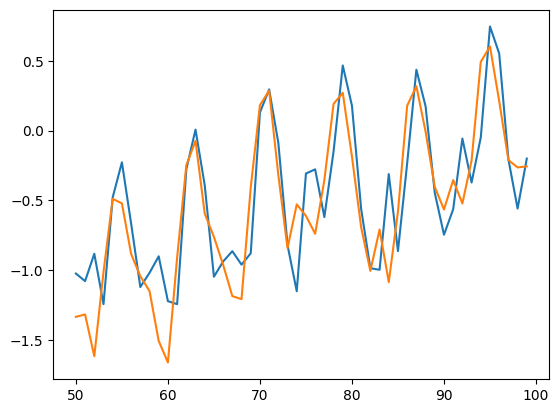

In [ ]:
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [ ]:
val_predictions = model2.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

313/313 [==============================] - 1s 4ms/step


,Val Predictions,Actuals
0,1.681565,1.879969
1,1.153909,1.739445
2,1.280047,1.393604
3,1.287365,1.286418
4,1.294240,0.920981
...,...,...
9995,0.038425,-0.549637
9996,-0.364825,-0.695221
9997,-0.617618,0.133097
9998,0.695501,0.856093


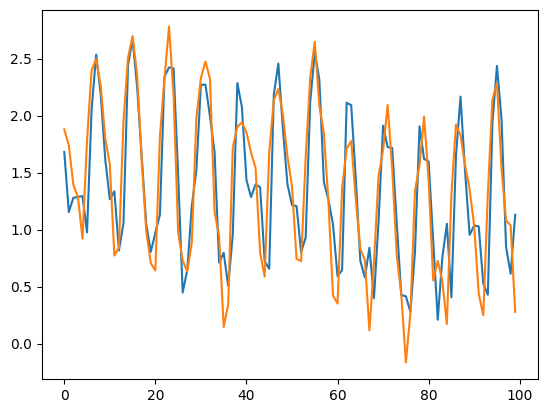

In [ ]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

211/211 [==============================] - 1s 3ms/step


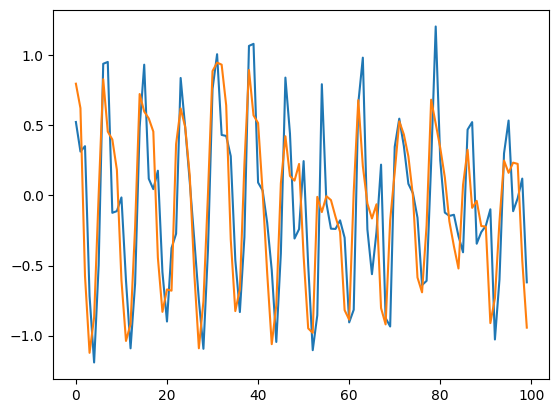

In [ ]:
test_predictions = model2.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [ ]:
# Adding more variables other than time, basically the sine and cosine of the time with the daily and yearly frequencies

In [ ]:
temp_df = pd.DataFrame({'Temp(K)': temp, 'Time': Time})

temp_df['Temp(K)'] = (temp_df['Temp(K)'] - temp_mean)/temp_std
temp_df.index = temp_df['Time']

In [ ]:
day = 60*60*24
year = 365.2425*day

temp_df['Day sin'] = np.sin(temp_df['Time'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Time'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Time'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Time'] * (2 * np.pi / year))
temp_df.head()

,Temp(K),Time,Day sin,Day cos,Year sin,Year cos
Time,,,,,,
631152000.0,-1.690695,631152000.0,-2.208429e-12,1.000000e+00,0.002580,0.999997
631162800.0,-1.819432,631162800.0,7.071068e-01,7.071068e-01,0.004731,0.999989
631173600.0,-1.401878,631173600.0,1.000000e+00,4.771773e-12,0.006881,0.999976
631184400.0,-0.505685,631184400.0,7.071068e-01,-7.071068e-01,0.009031,0.999959
631195200.0,-0.134149,631195200.0,5.915988e-14,-1.000000e+00,0.011182,0.999937


In [ ]:
temp_df = temp_df.drop('Time', axis=1)
temp_df.head()

,Temp(K),Day sin,Day cos,Year sin,Year cos
Time,,,,,
631152000.0,-1.690695,-2.208429e-12,1.000000e+00,0.002580,0.999997
631162800.0,-1.819432,7.071068e-01,7.071068e-01,0.004731,0.999989
631173600.0,-1.401878,1.000000e+00,4.771773e-12,0.006881,0.999976
631184400.0,-0.505685,7.071068e-01,-7.071068e-01,0.009031,0.999959
631195200.0,-0.134149,5.915988e-14,-1.000000e+00,0.011182,0.999937


In [ ]:
# Function to create x and y labels, here each x label(here 8 points or whatever you want) has x points each of which is an array of 5 variables unlike the previous one which only had 1 variable 
def df_to_X_y2(df, window_size=8):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((46744, 8, 5), (46744,))

In [ ]:
X2_train, y2_train = X2[:30000], y2[:30000]
X2_val, y2_val = X2[30000:40000], y2[30000:40000]
X2_test, y2_test = X2[40000:], y2[40000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape
print(X2_train)

[[[-1.69069493e+00 -2.20842919e-12  1.00000000e+00  2.58041370e-03
    9.99996671e-01]
  [-1.81943238e+00  7.07106781e-01  7.07106781e-01  4.73074605e-03
    9.99988810e-01]
  [-1.40187776e+00  1.00000000e+00  4.77177334e-12  6.88105653e-03
    9.99976325e-01]
  ...
  [-6.34463608e-01 -7.07106781e-01 -7.07106781e-01  1.33317573e-02
    9.99911128e-01]
  [-9.95923340e-01 -1.00000000e+00 -2.62250403e-12  1.54818808e-02
    9.99880149e-01]
  [-1.67955911e+00 -7.07106781e-01  7.07106781e-01  1.76319328e-02
    9.99844545e-01]]

 [[-1.81943238e+00  7.07106781e-01  7.07106781e-01  4.73074605e-03
    9.99988810e-01]
  [-1.40187776e+00  1.00000000e+00  4.77177334e-12  6.88105653e-03
    9.99976325e-01]
  [-5.05684674e-01  7.07106781e-01 -7.07106781e-01  9.03133519e-03
    9.99959217e-01]
  ...
  [-9.95923340e-01 -1.00000000e+00 -2.62250403e-12  1.54818808e-02
    9.99880149e-01]
  [-1.67955911e+00 -7.07106781e-01  7.07106781e-01  1.76319328e-02
    9.99844545e-01]
  [-1.76593614e+00 -5.1858481

In [ ]:
# Normalizing temp
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[-6.77108612e+01, -2.69411154e-12,  1.00000000e+00,
         -9.29650885e-01, -3.68441627e-01],
        [-6.77434781e+01,  7.07106781e-01,  7.07106781e-01,
         -9.30441012e-01, -3.66441705e-01],
        [-6.75578988e+01,  1.00000000e+00,  5.25745569e-12,
         -9.31226837e-01, -3.64440088e-01],
        ...,
        [-6.74093331e+01, -7.07106781e-01, -7.07106781e-01,
         -9.33558462e-01, -3.58425163e-01],
        [-6.74483962e+01, -1.00000000e+00, -1.03841440e-11,
         -9.34327042e-01, -3.56416861e-01],
        [-6.77164316e+01, -7.07106781e-01,  7.07106781e-01,
         -9.35091301e-01, -3.54406911e-01]],

       [[-6.77434781e+01,  7.07106781e-01,  7.07106781e-01,
         -9.30441012e-01, -3.66441705e-01],
        [-6.75578988e+01,  1.00000000e+00,  5.25745569e-12,
         -9.31226837e-01, -3.64440088e-01],
        [-6.73959162e+01,  7.07106781e-01, -7.07106781e-01,
         -9.32008356e-01, -3.62436786e-01],
        ...,
        [-6.74483962e+01, -1.0000000

In [ ]:
model4 = Sequential()
model4.add(InputLayer((8, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17920     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=15, callbacks=[cp4])

Epoch 1/15
938/938 [==============================] - 9s 9ms/step - loss: 0.2133 - root_mean_squared_error: 0.4619 - val_loss: 0.2411 - val_root_mean_squared_error: 0.4910
Epoch 2/15
938/938 [==============================] - 8s 8ms/step - loss: 0.2126 - root_mean_squared_error: 0.4610 - val_loss: 0.2312 - val_root_mean_squared_error: 0.4808
Epoch 3/15
938/938 [==============================] - 8s 8ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586 - val_loss: 0.2392 - val_root_mean_squared_error: 0.4890
Epoch 4/15
938/938 [==============================] - ETA: 0s - loss: 0.2101 - root_mean_squared_error: 0.4584

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


938/938 [==============================] - 14s 15ms/step - loss: 0.2101 - root_mean_squared_error: 0.4584 - val_loss: 0.2274 - val_root_mean_squared_error: 0.4769
Epoch 5/15
933/938 [============================>.] - ETA: 0s - loss: 0.2084 - root_mean_squared_error: 0.4565

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


938/938 [==============================] - 16s 17ms/step - loss: 0.2085 - root_mean_squared_error: 0.4566 - val_loss: 0.2236 - val_root_mean_squared_error: 0.4728
Epoch 6/15
938/938 [==============================] - 9s 9ms/step - loss: 0.2086 - root_mean_squared_error: 0.4567 - val_loss: 0.2364 - val_root_mean_squared_error: 0.4862
Epoch 7/15
938/938 [==============================] - 8s 9ms/step - loss: 0.2066 - root_mean_squared_error: 0.4545 - val_loss: 0.2351 - val_root_mean_squared_error: 0.4849
Epoch 8/15
938/938 [==============================] - ETA: 0s - loss: 0.2061 - root_mean_squared_error: 0.4539

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


938/938 [==============================] - 14s 15ms/step - loss: 0.2061 - root_mean_squared_error: 0.4539 - val_loss: 0.2152 - val_root_mean_squared_error: 0.4639
Epoch 9/15
938/938 [==============================] - 8s 9ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529 - val_loss: 0.2293 - val_root_mean_squared_error: 0.4788
Epoch 10/15
938/938 [==============================] - 8s 9ms/step - loss: 0.2036 - root_mean_squared_error: 0.4513 - val_loss: 0.2308 - val_root_mean_squared_error: 0.4805
Epoch 11/15
938/938 [==============================] - 9s 9ms/step - loss: 0.2035 - root_mean_squared_error: 0.4511 - val_loss: 0.2513 - val_root_mean_squared_error: 0.5013
Epoch 12/15
938/938 [==============================] - 8s 9ms/step - loss: 0.2023 - root_mean_squared_error: 0.4498 - val_loss: 0.2209 - val_root_mean_squared_error: 0.4700
Epoch 13/15
938/938 [==============================] - 9s 9ms/step - loss: 0.2022 - root_mean_squared_error: 0.4497 - val_loss: 0.2181 - val_root_

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


938/938 [==============================] - 15s 16ms/step - loss: 0.2012 - root_mean_squared_error: 0.4486 - val_loss: 0.2124 - val_root_mean_squared_error: 0.4609
Epoch 15/15
938/938 [==============================] - 8s 9ms/step - loss: 0.2011 - root_mean_squared_error: 0.4484 - val_loss: 0.2270 - val_root_mean_squared_error: 0.4764


In [ ]:
model4 = load_model('model4/')

In [ ]:
train_predictions_2 = model4.predict(X2_train).flatten()
train_results_2 = pd.DataFrame(data={'Train Predictions': train_predictions_2, 'Actuals': y2_train})
train_results_2

938/938 [==============================] - 4s 4ms/step


,Train Predictions,Actuals
0,-1.610320,-1.765936
1,-1.734368,-1.781645
2,-0.915352,-1.497741
3,-0.118316,-0.583864
4,-0.111954,-0.257253
...,...,...
29995,1.782824,2.247312
29996,1.954324,2.156472
29997,1.587562,1.879920
29998,0.907056,1.739396


211/211 [==============================] - 1s 4ms/step


(      Predictions   Actuals
 0       -0.797949 -1.122395
 1       -0.778444 -0.870110
 2       -0.368550  0.006153
 3        0.168367  0.827965
 4        0.321983  0.454434
 ...           ...       ...
 6739    -0.123632 -0.332106
 6740    -0.128788 -0.418601
 6741    -0.666018 -0.948407
 6742    -1.078574 -1.241410
 6743    -1.343250 -1.444696
 
 [6744 rows x 2 columns],
 0.2057656185512952)

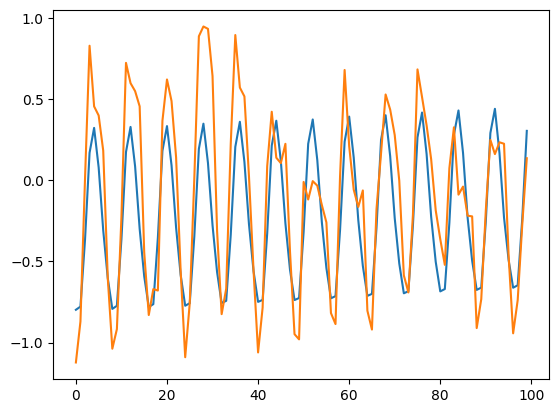

In [ ]:
plot_predictions1(model4, X2_test, y2_test)

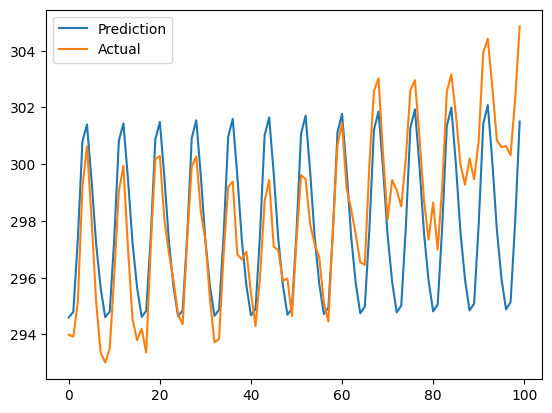

In [ ]:
plt.plot((train_results['Train Predictions'][:100]*temp_std) +temp_mean, label="Prediction")
plt.plot((train_results['Actuals'][:100]*temp_std) + temp_mean, label="Actual")
plt.legend()